In [24]:
# !pip install ultralyticsplus 

In [30]:
!pip install PyQt5

  Obtaining dependency information for PyQt5 from https://files.pythonhosted.org/packages/2f/e6/a1f9853e4933c312c6de9c79d126c7d92ef69ae0e53895fb1ceb0ecc77a6/PyQt5-5.15.10-cp37-abi3-manylinux_2_17_x86_64.whl.metadata
  Obtaining dependency information for PyQt5-sip<13,>=12.13 from https://files.pythonhosted.org/packages/c9/d5/2537affe91240214b4b84616ef6abe545bca6a56302280cad5e08062b23b/PyQt5_sip-12.13.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 35.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 63.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 38.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### Imports

In [51]:
import os
import pickle
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont

from PIL import Image, ImageDraw
from ultralytics import YOLO
from ultralyticsplus import render_result


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [32]:
from object_detection_utils import (
    COLORS,
    preprocess, 
    box_cxcywh_to_xyxy, 
    rescale_bboxes,
    batch_detect,
    detect, 
    plot_results,
    plot_batch_detections,
    plot_batch_detections,
    plot_results_avenue,
    load_images_from_folder,
    list_image_files,
    save_cropped_images,
)

In [33]:
def plot_results_avenue(pil_img, prob, boxes, im_size=(640, 360), display_img=True, save_path=None, crop_objects=False):
    orig_width, orig_height = pil_img.size
    scale_x = orig_width / im_size[0]
    scale_y = orig_height / im_size[1]

    # Create a copy of the image for cropping
    pil_img_copy = pil_img.copy()

    draw = ImageDraw.Draw(pil_img)
    font = ImageFont.load_default()  # Can be changed to another font

    cropped_images = []  # List to hold cropped objects

    for (xmin, ymin, xmax, ymax), c in zip(boxes, COLORS * 100):
        xmin, xmax = xmin * scale_x, xmax * scale_x
        ymin, ymax = ymin * scale_y, ymax * scale_y

        color = tuple(int(255 * x) for x in c)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)

        if crop_objects:
            # Cropping from the unaltered image copy
            cropped_obj = pil_img_copy.crop((xmin, ymin, xmax, ymax))
            cropped_images.append(cropped_obj)

        # Optionally add class text
        # cl = p.argmax()
        # text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        # draw.text((xmin, ymin), text, fill=color, font=font)

    if display_img:
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        plt.axis('off')
        plt.show()

    if save_path:
        pil_img.save(save_path)

    return pil_img, cropped_images

### Load Model

In [34]:
# load model
model = YOLO('./pretrained/yolov8x')

### Test on 1 Img

In [35]:
transform = T.Compose([
    # T.Resize((500, 500)),  # Assuming 800 is the input size for the model
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [36]:
# image_tensor, image = preprocess("./assets/demo6.jpg", transform=transform)

In [37]:
image_tensor, image = preprocess("./datasets/Avenue Dataset/train__/01/0017.jpg", transform=transform)

In [38]:
# %%timeit -n 100
# # benchmark
# with torch.no_grad():
#     # Run the model on the batch
#     outputs = model(pixel_values=batch_images)

In [39]:
%%capture
results = model.predict(image, conf=0.7, agnostic_nms=False, max_det=20, iou=0.45, imgsz=(640, 360))

Ultralytics YOLOv8.0.43 🚀 Python-3.10.8 torch-1.13.0+cu116 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 4 persons, 33.7ms
Speed: 0.5ms preprocess, 33.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[[403, 100, 446, 235], [443, 105, 488, 236], [223, 113, 274, 232], [301, 116, 361, 231]]


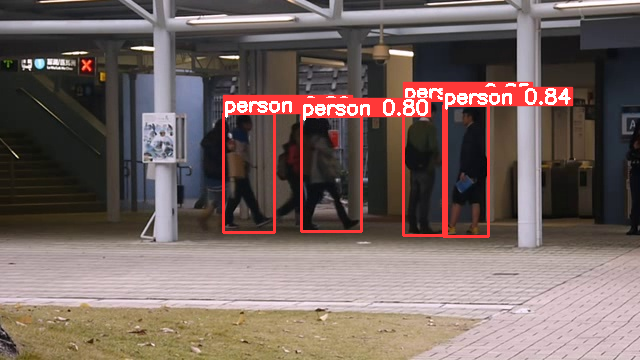

In [40]:
# observe results
print(results[0].boxes.xyxy.int().tolist())
render = render_result(model=model, image=image, result=results[0])
render.show()

In [41]:
render.size

(640, 360)

In [46]:
boxes_list = results[0].boxes.xyxy.int().tolist()
print(boxes_list)

[[403, 100, 446, 235], [443, 105, 488, 236], [223, 113, 274, 232], [301, 116, 361, 231]]


In [49]:
image.size

(640, 360)

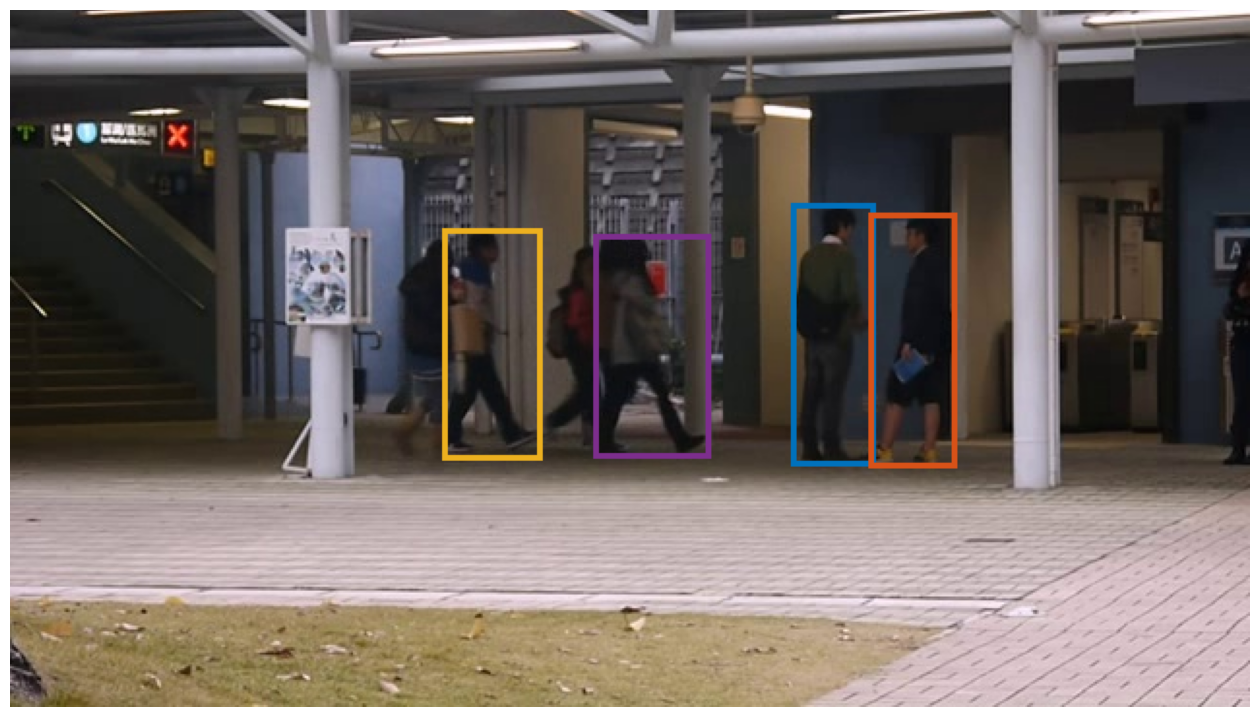

In [48]:
# This function can now also create images with bounding boxes and the cropped objects and save them to a location
_, cropped_objects = plot_results_avenue(image, 0.5, boxes_list, im_size=(640, 360), display_img=True, save_path=None, crop_objects=True)

### Avenue Prediction using YOLOv8

In [10]:
train_dir = "./datasets/Avenue Dataset/train__/"
train_video_dirs = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16"]
train_video_paths = []
total_frames = 0
for dir in train_video_dirs:
    cur_dir = os.path.join(train_dir, dir)
    train_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/train__/01 1364
./datasets/Avenue Dataset/train__/02 1511
./datasets/Avenue Dataset/train__/03 1487
./datasets/Avenue Dataset/train__/04 1511
./datasets/Avenue Dataset/train__/05 815
./datasets/Avenue Dataset/train__/06 1511
./datasets/Avenue Dataset/train__/07 1099
./datasets/Avenue Dataset/train__/08 1017
./datasets/Avenue Dataset/train__/09 1391
./datasets/Avenue Dataset/train__/10 1223
./datasets/Avenue Dataset/train__/11 781
./datasets/Avenue Dataset/train__/12 145
./datasets/Avenue Dataset/train__/13 366
./datasets/Avenue Dataset/train__/14 510
./datasets/Avenue Dataset/train__/15 353
./datasets/Avenue Dataset/train__/16 244
Total Frames: 15328


In [11]:
test_dir = "./datasets/Avenue Dataset/test__/"
test_video_dirs = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21"]
test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/test__/01 1439
./datasets/Avenue Dataset/test__/02 1211
./datasets/Avenue Dataset/test__/03 923
./datasets/Avenue Dataset/test__/04 947
./datasets/Avenue Dataset/test__/05 1007
./datasets/Avenue Dataset/test__/06 1283
./datasets/Avenue Dataset/test__/07 605
./datasets/Avenue Dataset/test__/08 36
./datasets/Avenue Dataset/test__/09 1175
./datasets/Avenue Dataset/test__/10 841
./datasets/Avenue Dataset/test__/11 472
./datasets/Avenue Dataset/test__/12 1271
./datasets/Avenue Dataset/test__/13 549
./datasets/Avenue Dataset/test__/14 507
./datasets/Avenue Dataset/test__/15 1001
./datasets/Avenue Dataset/test__/16 740
./datasets/Avenue Dataset/test__/17 426
./datasets/Avenue Dataset/test__/18 294
./datasets/Avenue Dataset/test__/19 248
./datasets/Avenue Dataset/test__/20 273
./datasets/Avenue Dataset/test__/21 76
Total Frames: 15324


In [12]:
preds_path = "./datasets/Avenue Dataset/predictions/"
train_preds_path = os.path.join(preds_path, "train/")
test_preds_path = os.path.join(preds_path, "test/")
print(train_preds_path, test_preds_path)

./datasets/Avenue Dataset/predictions/train/ ./datasets/Avenue Dataset/predictions/test/


In [13]:
objects_path = "./datasets/Avenue Dataset/objects/"
train_objects_path = os.path.join(objects_path, "train/")
test_objects_path = os.path.join(objects_path, "test/")
print(train_objects_path, test_objects_path)

./datasets/Avenue Dataset/objects/train/ ./datasets/Avenue Dataset/objects/test/


In [14]:
image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[-1])]
print(image_names)

['00.jpg', '01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg', '06.jpg', '07.jpg', '08.jpg', '09.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg']


### Generate Train Objects and predictions

In [ ]:
%%capture
transform = T.Compose([
    T.Resize((640, 360)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
bbox_temp = {}
video_names = [video.split('/')[-1] for video in train_video_paths]
print(video_names)
# obj_det_dict = {}

for i, video_path in enumerate(train_video_paths):
    print(video_path)
    image_names = [img.split('/')[-1] for img in list_image_files(train_video_paths[i])]

    frame_idx = 0
    for image_name in image_names:
        full_image_path = os.path.join(train_video_paths[i], image_name)
        
        image_tensor, image = preprocess(full_image_path, transform=transform)
        
        # probab, boxes = detect(image, model)
        with torch.no_grad():
            results = model.predict(image, conf=0.7, agnostic_nms=False, max_det=20, iou=0.45, imgsz=(640, 360))

        # # Process boxes and convert to Python lists with integers
        # boxes_list = []
        # for box in boxes:
        #     int_box = [int(elem.item()) for elem in box]  # Convert each element to an int and then to a Python list
        #     boxes_list.append(int_box)

        boxes_list = results[0].boxes.xyxy.int().tolist()

        # TODO: Save this dict
        bbox_temp[frame_idx] = boxes_list

        frame_idx += 1
    
        image_prediction_path = os.path.join(train_preds_path, test_video_dirs[i], image_name)
        # print(image_prediction_path)
    
        # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        _, cropped_objects = plot_results_avenue(image, 0.5, boxes_list, im_size=(640, 360), display_img=False, save_path=image_prediction_path, crop_objects=True)
    
        objects_prediction_path = os.path.join(train_objects_path, test_video_dirs[i])
        
        save_cropped_images(cropped_objects, objects_prediction_path, image_prefix=image_name.split('.')[0])   
   
    # obj_det_dict[video_names[i]] = bbox_temp


WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 5 persons, 15.8ms
Speed: 0.3ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 4 persons, 17.4ms
Speed: 0.4ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 5 persons, 16.6ms
Speed: 0.4ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 5 persons, 16.4ms
Speed: 0.4ms preprocess, 16.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 4 persons, 17.0ms
Speed: 0.4ms preprocess, 17.0ms 

### Generate Test objects and predictions

In [ ]:
%%capture
transform = T.Compose([
    T.Resize((640, 360)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
bbox_temp = {}
video_names = [video.split('/')[-1] for video in test_video_paths]
print(video_names)
obj_det_dict = {}

for i, video_path in enumerate(test_video_paths[5:]):
    print(video_path)
    image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[i])]

    frame_idx = 0
    for image_name in image_names:
        full_image_path = os.path.join(test_video_paths[i], image_name)
        
        image_tensor, image = preprocess(full_image_path, transform=transform)
        
        # probab, boxes = detect(image, model)
        with torch.no_grad():
            results = model.predict(image, conf=0.7, agnostic_nms=False, max_det=20, iou=0.45, imgsz=(640, 360))

        # # Process boxes and convert to Python lists with integers
        # boxes_list = []
        # for box in boxes:
        #     int_box = [int(elem.item()) for elem in box]  # Convert each element to an int and then to a Python list
        #     boxes_list.append(int_box)

        boxes_list = results[0].boxes.xyxy.int().tolist()

        # For every frame of a video, we will store a list containing [xmin, ymin, xmax, ymax] for every detected object
        bbox_temp[frame_idx] = boxes_list

        frame_idx += 1
    
        image_prediction_path = os.path.join(test_preds_path, test_video_dirs[i], image_name)
        # print(image_prediction_path)
    
        # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        _, cropped_objects = plot_results_avenue(image, 0.5, boxes_list, im_size=(640, 360), display_img=False, save_path=image_prediction_path, crop_objects=True)
    
        objects_prediction_path = os.path.join(test_objects_path, test_video_dirs[i])
        
        save_cropped_images(cropped_objects, objects_prediction_path, image_prefix=image_name.split('.')[0])   
   
    obj_det_dict[video_names[i]] = bbox_temp


WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 1 person, 95.2ms
Speed: 0.7ms preprocess, 95.2ms inference, 10.9ms postprocess per image at shape (1, 3, 640, 384)

WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 2 persons, 86.7ms
Speed: 0.7ms preprocess, 86.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 2 persons, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 2 persons, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 2 persons, 8.6ms
Speed: 0.3ms preprocess, 8.6ms infe

In [ ]:
# # Save the object to a file
# with open('obj_dect_avenue_yolov8', 'wb') as file:
#     pickle.dump(obj_det_dict, file)

In [52]:
# Read obj_det_avenue_test
with open('obj_dect_avenue_yolov8', 'rb') as file:
    obj_dect_avenue = pickle.load(file)

In [53]:
obj_dect_avenue

{'01': {0: [[313, 107, 382, 267], [544, 130, 614, 293]],
  1: [[313, 106, 382, 268],
   [543, 130, 614, 294],
   [485, 109, 517, 222],
   [370, 121, 417, 231]],
  2: [[542, 131, 612, 294], [314, 105, 382, 267], [376, 121, 421, 230]],
  3: [[542, 131, 611, 294],
   [315, 105, 381, 267],
   [573, 93, 640, 285],
   [380, 121, 422, 230]],
  4: [[542, 132, 608, 293], [317, 105, 382, 267], [33, 104, 77, 232]],
  5: [[319, 107, 383, 267],
   [540, 132, 605, 293],
   [33, 105, 85, 232],
   [387, 119, 429, 231],
   [424, 121, 458, 225]],
  6: [[320, 108, 385, 267],
   [535, 133, 602, 293],
   [33, 106, 94, 232],
   [390, 119, 431, 231]],
  7: [[530, 134, 600, 293],
   [322, 108, 385, 267],
   [35, 107, 99, 232],
   [574, 95, 622, 287],
   [595, 81, 640, 283]],
  8: [[525, 139, 598, 293],
   [324, 108, 386, 266],
   [36, 107, 99, 232],
   [595, 81, 640, 283],
   [571, 95, 622, 287],
   [397, 120, 435, 231],
   [435, 122, 465, 225]],
  9: [[517, 138, 597, 293],
   [327, 108, 385, 265],
   [561, 9